# `AML — Task 2:` Heart rhythm classification from raw ECG signals.

---

In [1]:
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg

In [109]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

## Dataset import and export

In [3]:
def load_from_csv():
    X_train = pd.read_csv('data/X_train.csv').drop(columns=['id'])
    y_train = pd.read_csv('data/y_train.csv').drop(columns=['id'])
    X_test  = pd.read_csv('data/X_test.csv').drop(columns=['id'])
    return X_train, y_train, X_test

In [4]:
def export_to_csv(X_train, y_train, X_test):
    X_train.to_csv('data/X_train_cleaned.csv', index=False)
    y_train.to_csv('data/y_train_cleaned.csv', index=False)
    X_test.to_csv('data/X_test_cleaned.csv', index=False)

## Export `csv` submission file

In [5]:
def create_submission(sub_id, pred, basepath='submissions/task2-sub'):
    result = pred.copy().rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

## Data processing `TODO`

In [55]:
def series_to_heartbeats(time_series: pd.Series, sampling_rate=300.0) -> np.array:
    no_nans = time_series.dropna()
    rpeaks = ecg.engzee_segmenter(no_nans, sampling_rate)['rpeaks']
    beats, rpeaks = ecg.extract_heartbeats(no_nans, rpeaks, sampling_rate)
    return beats, rpeaks

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

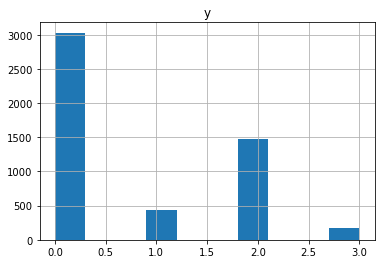

In [83]:
y_train.hist()

## Models defintion `TODO`

In [111]:
def best_svc(X_train, y_train):
    svc = SVC()
    gs_svc_params = {
        'kernel': ['rbf'],#, 'poly', 'sigmoid'],
        'C': [1.0]#np.logspace(0, 3, 6),
    }
    gs_svc = GridSearchCV(svc, gs_svc_params, cv=5, verbose=3, error_score='raise')
    gs_svc.fit(X_train, y_train)
    
    print(f"""The best validation score obtained is {gs_svc.best_score_:.5f} with
    \tkernel: {gs_svr.best_params_['kernel']}
    \tC: {gs_svr.best_params_['C']}""")
    
    return gs_svc

## Parameters tuning `TODO`

## Generate new submission

In [87]:
X_train, y_train, X_test = load_from_csv()

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5117 entries, 0 to 5116
Columns: 17842 entries, x0 to x17841
dtypes: float64(15352), int64(2490)
memory usage: 696.5 MB


In [90]:
X_train = X_train.dropna(axis='index', how='all')

In [91]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5117 entries, 0 to 5116
Columns: 17842 entries, x0 to x17841
dtypes: float64(15352), int64(2490)
memory usage: 696.6 MB


<AxesSubplot:>

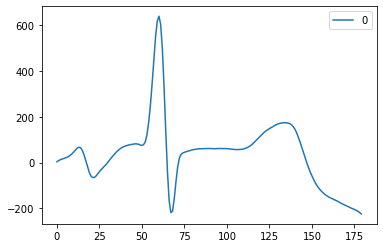

In [97]:
pd.DataFrame(np.mean(series_to_heartbeats(X_train.iloc[2384])[0], axis=0)).plot()

In [103]:
X_train = X_train.apply(lambda r: np.mean(series_to_heartbeats(r)[0], axis=0), axis=1)
X_test = X_test.apply(lambda r: np.mean(series_to_heartbeats(r)[0], axis=0), axis=1)

/Users/antoine/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/antoine/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [113]:
X_train

0       [-28.553846153846155, -26.6, -24.5384615384615...
1       [-6.694444444444445, -4.777777777777778, -2.22...
2       [4.6, 8.533333333333333, 12.433333333333334, 1...
3       [69.3076923076923, 71.26153846153846, 72.69230...
4       [-47.18181818181818, -49.27272727272727, -50.8...
                              ...                        
5112    [-58.04761904761905, -69.95238095238095, -83.7...
5113    [11.193548387096774, 10.612903225806452, 10.32...
5114    [-53.529411764705884, -51.55882352941177, -49....
5115    [-28.21875, -27.53125, -26.8125, -26.1875, -25...
5116    [-30.97872340425532, -29.595744680851062, -28....
Length: 5117, dtype: object

In [132]:
def coucou(r):
    print(type(r))
    return pd.DataFrame(r)

In [138]:
pd.DataFrame(X_train.iloc[-52])

,0
0,-34.233333
1,-33.800000
2,-33.266667
3,-32.700000
4,-32.000000
...,...
175,-57.800000
176,-56.766667
177,-54.866667
178,-52.800000


In [133]:
X_train.apply(lambda r: coucou(r))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

ValueError: DataFrame constructor not properly called!

In [127]:
tmp = X_train.apply(lambda r: pd.DataFrame(r))

ValueError: DataFrame constructor not properly called!

In [112]:
svc = best_svc(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


ValueError: setting an array element with a sequence.

In [ ]:
model = svc # modify here

In [ ]:
#sub_id = 1
#prediction = pd.DataFrame(model.predict(X_test))

In [ ]:
#create_submission(sub_id, prediction)

**Solutions must be submitted on the [project website](https://aml.ise.inf.ethz.ch/task2/).**